In [1]:
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
import scipy.sparse as sp
from scipy.sparse import load_npz, save_npz
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, average_precision_score
import time
from netgan import netgan
import sys
sys.path.insert(0, '../src/')
import utils

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hheidrich/miniconda3/envs/ne

#### Load the data

In [2]:
dataset = 'rt_gop'
#dataset = 'web_edu'
#dataset = "citeseer"
#dataset = "CORA_ML"
data_path = f'../data/datasets/{dataset}.npz'
_A_obs = load_npz(data_path)
_N = _A_obs.shape[0]

In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

## Logs

In [6]:
def save_netgan_logs(log_dict, path, num_edges):
    
    overlaps = {i+1:overlap for i, overlap in enumerate(np.array(log_dict['edge_overlaps'])/num_edges)}
    timings = {i+1: timing for i, timing in enumerate(log_dict['times'])}
    
    val_perfs = np.array(log_dict['val_performances'])
    roc_aucs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,0])}
    avg_precs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,1])}
    
    dcts = {'overlap': overlaps,
            'timing': timings,
            'ROC-AUC': roc_aucs,
            'avg_prec': avg_precs,}
    
    str_len = len(str(len(log_dict['generated_graphs'])))
    Path(path).mkdir(parents=True, exist_ok=True)
    for name, dct in dcts.items():
        utils.save_dict(dct, os.path.join(path, f'{name}.pickle'))
    for i, graph in enumerate(log_dict['generated_graphs']):
        save_npz(matrix=sp.csr_matrix(graph), file=os.path.join(path, f'graph_{i+1:0{str_len}d}'))

In [7]:
def run_multiple_netgan_experiments(num_experiments,
                                    log_path,
                                    train_graph,
                                    val_ones,
                                    val_zeros,
                                    max_iters=200000,
                                    eval_every=2000,
                                    plot_every=2000,
                                    rw_len=16,
                                    batch_size=128):
    str_len = len(str(num_experiments-1))
    walker = netgan.utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)
    for i in range(num_experiments):
        # create model
        model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
        # train model
        log_dict = model.train(A_orig=train_graph, val_ones=val_ones, val_zeros=val_zeros, stopping=1.0,
                               eval_every=eval_every, plot_every=plot_every, max_patience=20,
                               max_iters=max_iters)
        
        # save logs
        save_netgan_logs(log_dict=log_dict,
                         path=os.path.join(log_path, f'Experiment_{i:0{str_len}d}/sampled_graphs/'),
                         num_edges=train_graph.sum())
        
        # close session
        model.session.close()
        # reset graph
        tf.reset_default_graph()

In [8]:
run_multiple_netgan_experiments(num_experiments=5,
                                log_path='../logs/citeseer/baseline_NetGan/',
                                train_graph=train_graph,
                                val_ones=val_ones,
                                val_zeros=val_zeros,
                                max_iters=200000)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


KeyboardInterrupt: 

## Training

In [6]:
def train_to_eo_and_save_models(target_eo,
                                num_models,
                                dataset,
                                train_graph,
                                val_ones,
                                val_zeros,
                                max_iters=200000,
                                eval_every=2000,
                                plot_every=2000,
                                rw_len=16,
                                batch_size=128):
    str_len = len(str(num_models-1))
    directory = os.path.join('../models',
                             dataset,
                             f'netgan_eo_{int(100*target_eo)}')
    Path(directory).mkdir(parents=True, exist_ok=True)
    
    walker = netgan.utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)
                                 
    for i in range(num_models):
        
        # create model
        model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
        # train model
        log_dict = model.train(A_orig=train_graph, val_ones=val_ones, val_zeros=val_zeros,
                               stopping=target_eo, eval_every=eval_every, plot_every=plot_every, max_patience=20,
                               max_iters=max_iters)
        
        #save_model
        saver = tf.train.Saver()
        _ = saver.save(model.session, os.path.join(directory, f'model_{i:0{str_len}d}.ckpt'))
        # close session
        model.session.close()
        # reset graph
        tf.reset_default_graph()




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
**** Using EO criterion of 0.52 for early stopping
**** Saving snapshots into ../snapshots/model_best_55.ckpt ****
**** Initializing... ****
**** Done.           ****



**** Starting training. ****


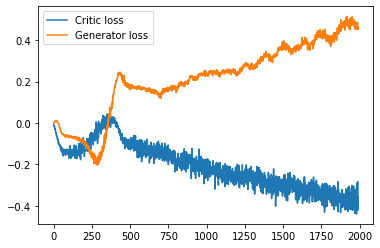

**** Iter 2000   Val ROC 0.856, AP: 0.861, EO 0.001 ****
2500   /200000   training iterations, took 346 seconds so far...


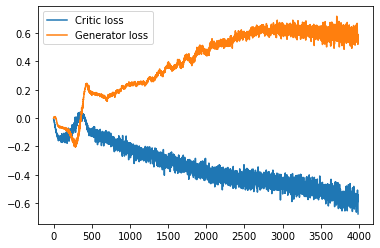

**** Iter 4000   Val ROC 0.850, AP: 0.856, EO 0.009 ****
5000   /200000   training iterations, took 682 seconds so far...


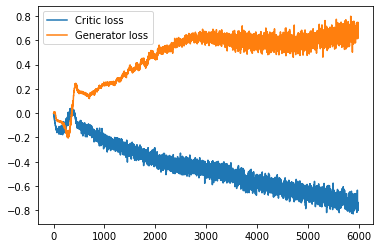

**** Iter 6000   Val ROC 0.851, AP: 0.857, EO 0.013 ****
7500   /200000   training iterations, took 1025 seconds so far...


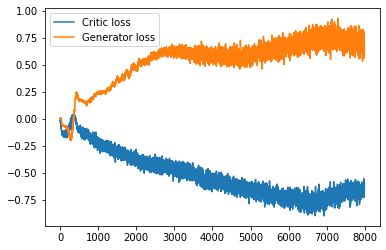

**** Iter 8000   Val ROC 0.851, AP: 0.851, EO 0.039 ****


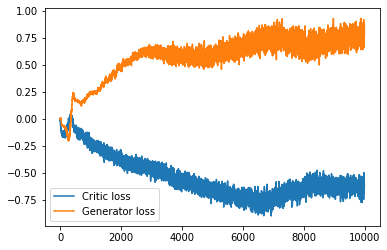

10000  /200000   training iterations, took 1366 seconds so far...
**** Iter 10000  Val ROC 0.826, AP: 0.828, EO 0.082 ****


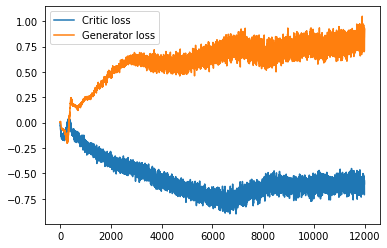

**** Iter 12000  Val ROC 0.830, AP: 0.834, EO 0.100 ****
12500  /200000   training iterations, took 1766 seconds so far...


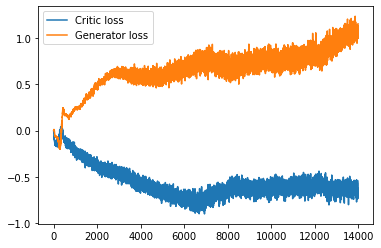

**** Iter 14000  Val ROC 0.819, AP: 0.822, EO 0.095 ****
15000  /200000   training iterations, took 2104 seconds so far...


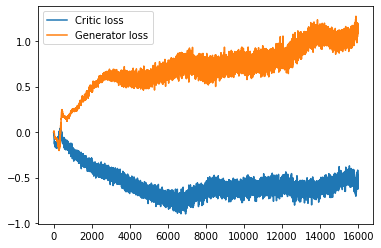

**** Iter 16000  Val ROC 0.818, AP: 0.818, EO 0.090 ****
17500  /200000   training iterations, took 2441 seconds so far...


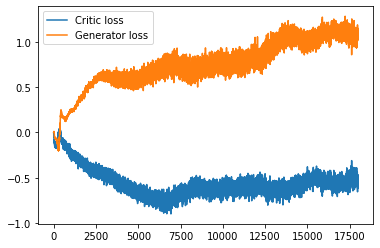

**** Iter 18000  Val ROC 0.815, AP: 0.815, EO 0.099 ****


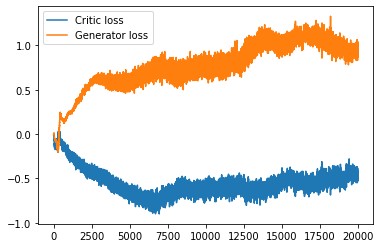

20000  /200000   training iterations, took 2778 seconds so far...
**** Iter 20000  Val ROC 0.818, AP: 0.816, EO 0.120 ****


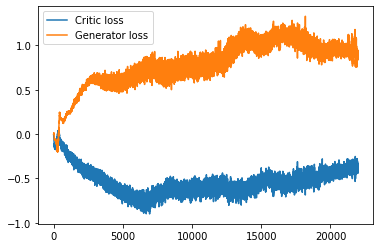

**** Iter 22000  Val ROC 0.806, AP: 0.798, EO 0.120 ****
22500  /200000   training iterations, took 3179 seconds so far...


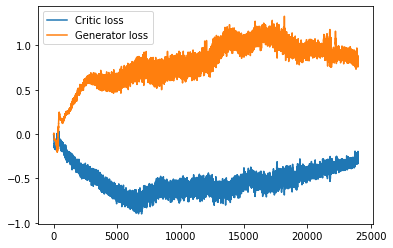

**** Iter 24000  Val ROC 0.801, AP: 0.794, EO 0.166 ****
25000  /200000   training iterations, took 3516 seconds so far...


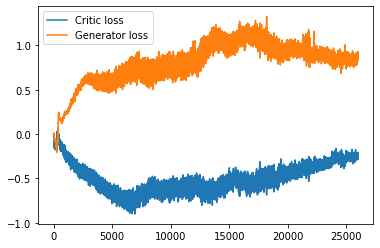

**** Iter 26000  Val ROC 0.797, AP: 0.785, EO 0.178 ****
27500  /200000   training iterations, took 3854 seconds so far...


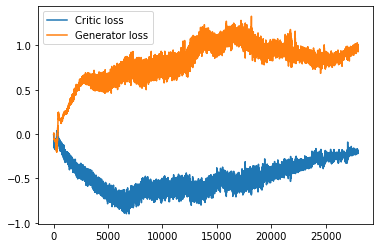

**** Iter 28000  Val ROC 0.789, AP: 0.773, EO 0.179 ****


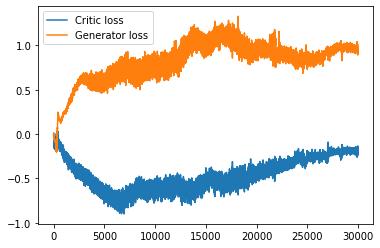

30000  /200000   training iterations, took 4191 seconds so far...
**** Iter 30000  Val ROC 0.776, AP: 0.770, EO 0.236 ****


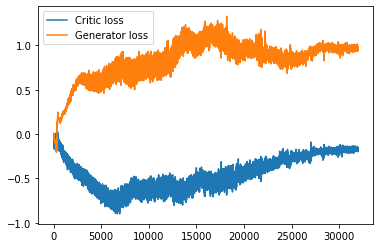

**** Iter 32000  Val ROC 0.752, AP: 0.746, EO 0.248 ****
32500  /200000   training iterations, took 4592 seconds so far...


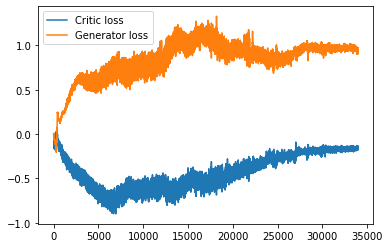

**** Iter 34000  Val ROC 0.751, AP: 0.750, EO 0.253 ****
35000  /200000   training iterations, took 4929 seconds so far...


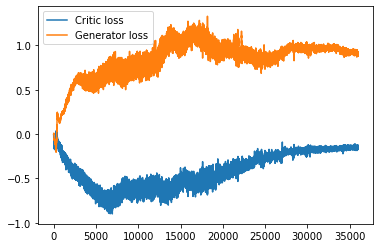

**** Iter 36000  Val ROC 0.714, AP: 0.718, EO 0.283 ****
37500  /200000   training iterations, took 5266 seconds so far...


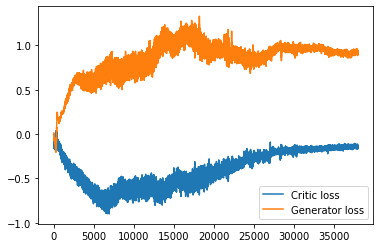

**** Iter 38000  Val ROC 0.720, AP: 0.716, EO 0.272 ****


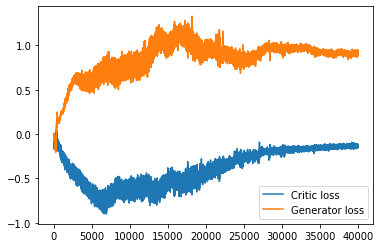

40000  /200000   training iterations, took 5604 seconds so far...
**** Iter 40000  Val ROC 0.732, AP: 0.734, EO 0.315 ****


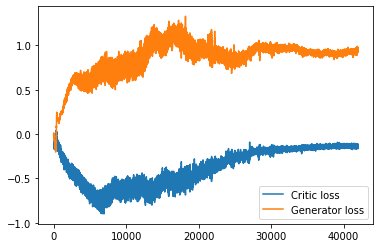

**** Iter 42000  Val ROC 0.710, AP: 0.715, EO 0.328 ****
42500  /200000   training iterations, took 6004 seconds so far...


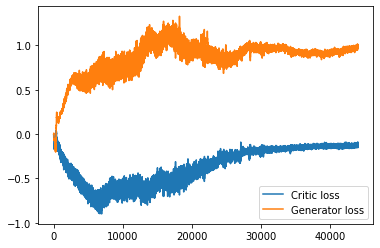

**** Iter 44000  Val ROC 0.689, AP: 0.695, EO 0.309 ****
45000  /200000   training iterations, took 6342 seconds so far...


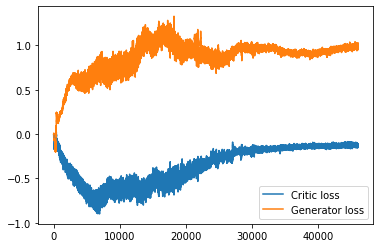

**** Iter 46000  Val ROC 0.716, AP: 0.714, EO 0.337 ****
47500  /200000   training iterations, took 6679 seconds so far...


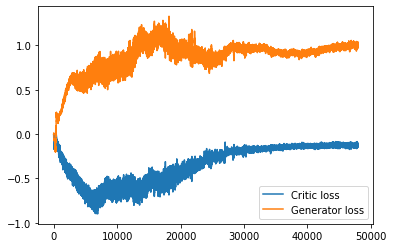

**** Iter 48000  Val ROC 0.722, AP: 0.722, EO 0.322 ****


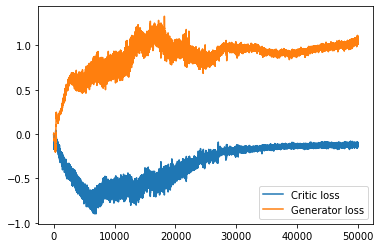

50000  /200000   training iterations, took 7016 seconds so far...
**** Iter 50000  Val ROC 0.697, AP: 0.698, EO 0.336 ****


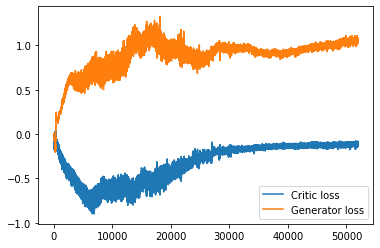

**** Iter 52000  Val ROC 0.690, AP: 0.692, EO 0.351 ****
52500  /200000   training iterations, took 7417 seconds so far...


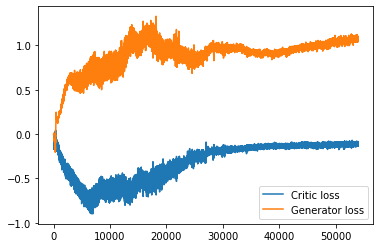

**** Iter 54000  Val ROC 0.701, AP: 0.703, EO 0.339 ****
55000  /200000   training iterations, took 7754 seconds so far...


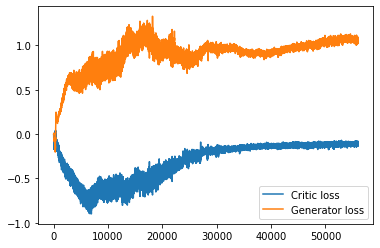

**** Iter 56000  Val ROC 0.699, AP: 0.704, EO 0.341 ****
57500  /200000   training iterations, took 8091 seconds so far...


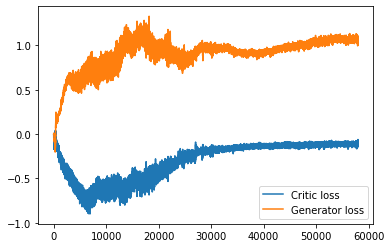

**** Iter 58000  Val ROC 0.690, AP: 0.692, EO 0.340 ****


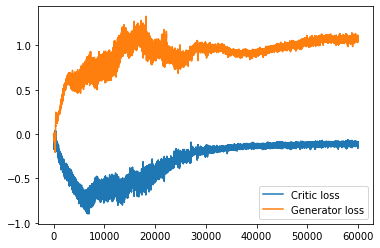

60000  /200000   training iterations, took 8429 seconds so far...
**** Iter 60000  Val ROC 0.722, AP: 0.721, EO 0.359 ****


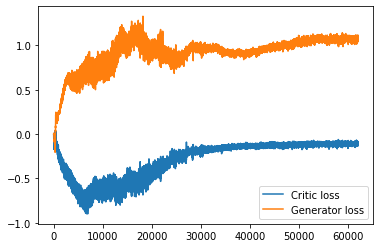

**** Iter 62000  Val ROC 0.696, AP: 0.700, EO 0.374 ****
62500  /200000   training iterations, took 8829 seconds so far...


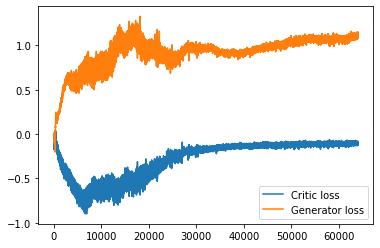

**** Iter 64000  Val ROC 0.695, AP: 0.701, EO 0.365 ****
65000  /200000   training iterations, took 9166 seconds so far...


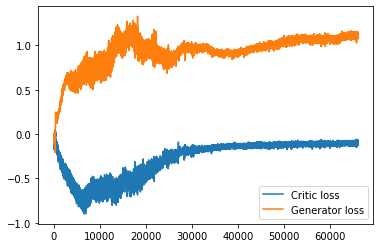

**** Iter 66000  Val ROC 0.681, AP: 0.682, EO 0.390 ****
67500  /200000   training iterations, took 9503 seconds so far...


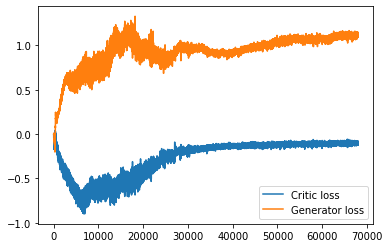

**** Iter 68000  Val ROC 0.695, AP: 0.700, EO 0.366 ****


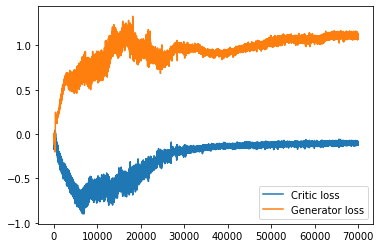

70000  /200000   training iterations, took 9841 seconds so far...
**** Iter 70000  Val ROC 0.701, AP: 0.698, EO 0.382 ****


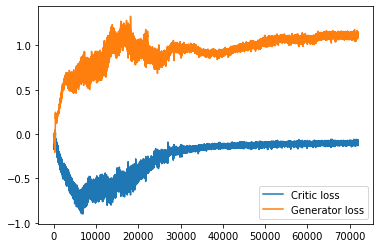

**** Iter 72000  Val ROC 0.688, AP: 0.690, EO 0.404 ****
72500  /200000   training iterations, took 10242 seconds so far...


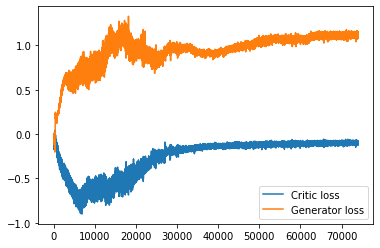

**** Iter 74000  Val ROC 0.687, AP: 0.687, EO 0.405 ****
75000  /200000   training iterations, took 10579 seconds so far...


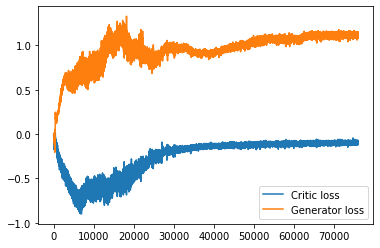

**** Iter 76000  Val ROC 0.689, AP: 0.687, EO 0.412 ****
77500  /200000   training iterations, took 10916 seconds so far...


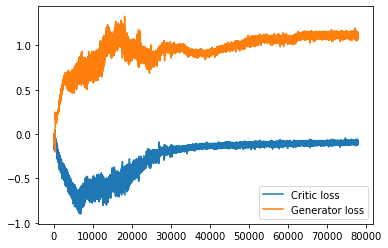

**** Iter 78000  Val ROC 0.687, AP: 0.688, EO 0.414 ****


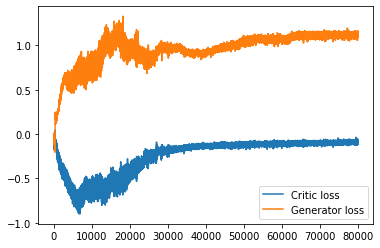

80000  /200000   training iterations, took 11254 seconds so far...
**** Iter 80000  Val ROC 0.681, AP: 0.686, EO 0.424 ****


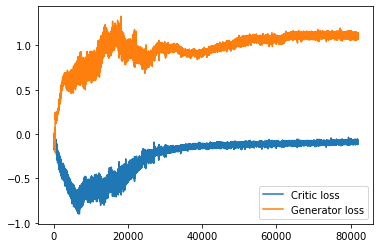

**** Iter 82000  Val ROC 0.688, AP: 0.692, EO 0.437 ****
82500  /200000   training iterations, took 11654 seconds so far...


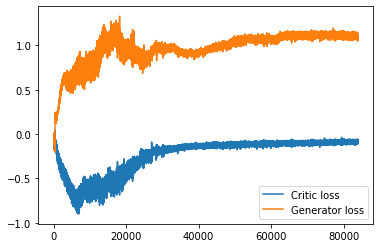

**** Iter 84000  Val ROC 0.691, AP: 0.688, EO 0.441 ****
85000  /200000   training iterations, took 11992 seconds so far...


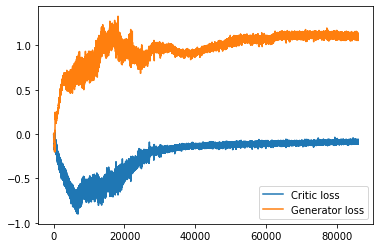

**** Iter 86000  Val ROC 0.687, AP: 0.691, EO 0.445 ****
87500  /200000   training iterations, took 12329 seconds so far...


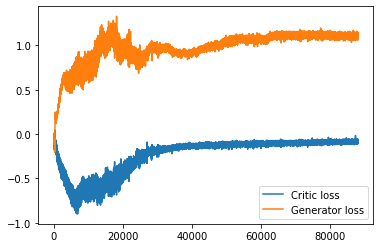

**** Iter 88000  Val ROC 0.721, AP: 0.716, EO 0.445 ****


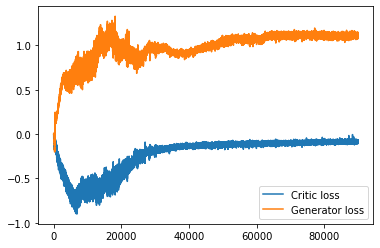

90000  /200000   training iterations, took 12667 seconds so far...
**** Iter 90000  Val ROC 0.683, AP: 0.684, EO 0.436 ****


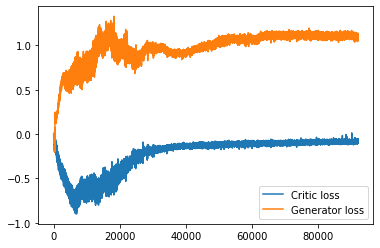

**** Iter 92000  Val ROC 0.674, AP: 0.680, EO 0.464 ****
92500  /200000   training iterations, took 13068 seconds so far...


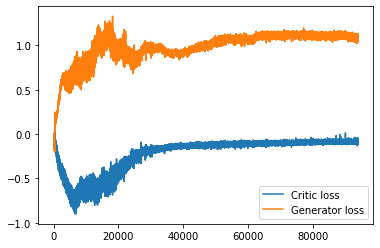

**** Iter 94000  Val ROC 0.683, AP: 0.682, EO 0.458 ****
95000  /200000   training iterations, took 13406 seconds so far...


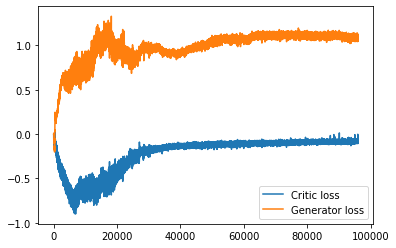

**** Iter 96000  Val ROC 0.676, AP: 0.680, EO 0.472 ****
97500  /200000   training iterations, took 13744 seconds so far...


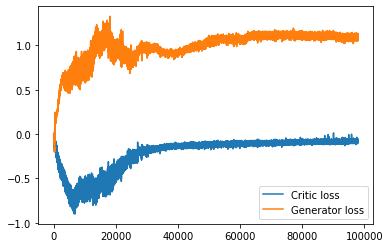

**** Iter 98000  Val ROC 0.689, AP: 0.688, EO 0.471 ****


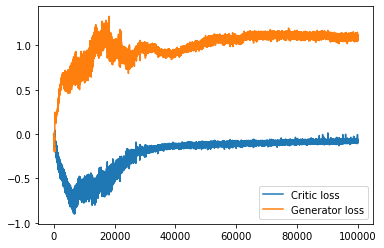

100000 /200000   training iterations, took 14082 seconds so far...
**** Iter 100000 Val ROC 0.683, AP: 0.682, EO 0.466 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


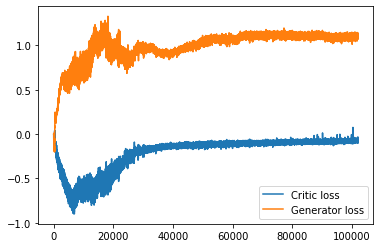

**** Iter 102000 Val ROC 0.685, AP: 0.686, EO 0.479 ****
102500 /200000   training iterations, took 14483 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


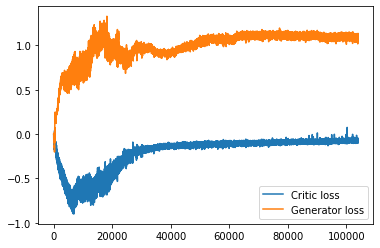

**** Iter 104000 Val ROC 0.680, AP: 0.681, EO 0.488 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


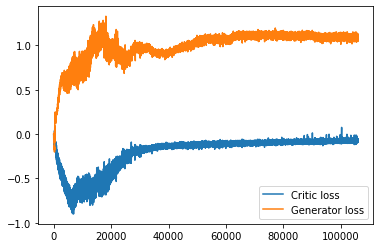

**** Iter 106000 Val ROC 0.663, AP: 0.665, EO 0.491 ****
107500 /200000   training iterations, took 15158 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


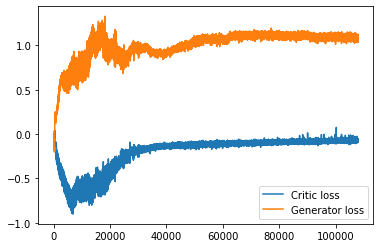

**** Iter 108000 Val ROC 0.676, AP: 0.672, EO 0.498 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


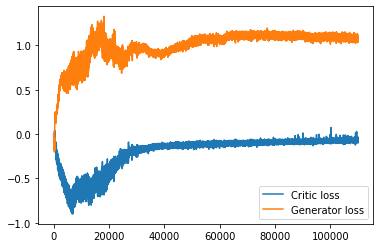

110000 /200000   training iterations, took 15496 seconds so far...
**** Iter 110000 Val ROC 0.676, AP: 0.669, EO 0.511 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


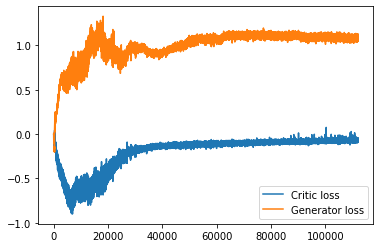

**** Iter 112000 Val ROC 0.681, AP: 0.675, EO 0.516 ****
112500 /200000   training iterations, took 15896 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


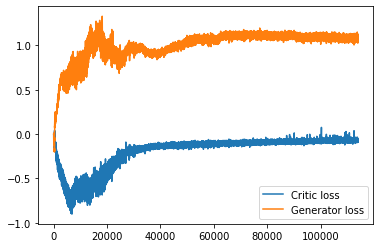

**** Iter 114000 Val ROC 0.665, AP: 0.659, EO 0.525 ****
**** EARLY STOPPING AFTER 114000 ITERATIONS ****
**** Training completed after 114000 iterations. ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


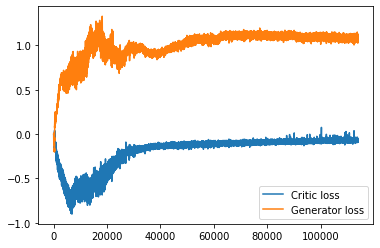

**** Using EO criterion of 0.52 for early stopping
**** Saving snapshots into ../snapshots/model_best_56.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****


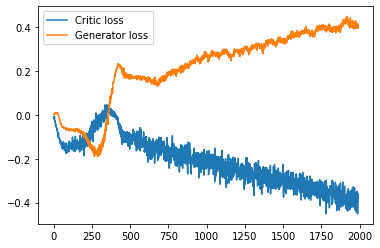

**** Iter 2000   Val ROC 0.857, AP: 0.856, EO 0.002 ****
2500   /200000   training iterations, took 342 seconds so far...


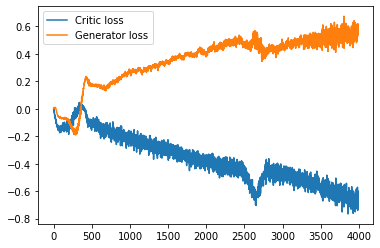

**** Iter 4000   Val ROC 0.842, AP: 0.843, EO 0.004 ****
5000   /200000   training iterations, took 680 seconds so far...


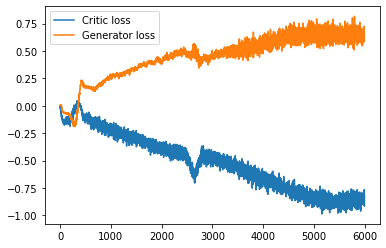

**** Iter 6000   Val ROC 0.846, AP: 0.848, EO 0.010 ****
7500   /200000   training iterations, took 1018 seconds so far...


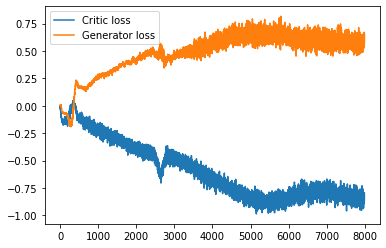

**** Iter 8000   Val ROC 0.848, AP: 0.848, EO 0.014 ****


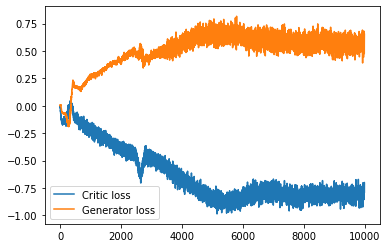

10000  /200000   training iterations, took 1356 seconds so far...
**** Iter 10000  Val ROC 0.838, AP: 0.841, EO 0.023 ****


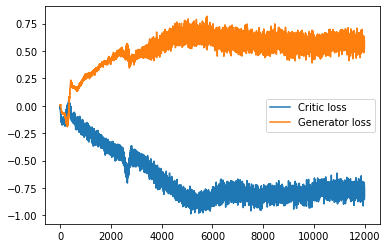

**** Iter 12000  Val ROC 0.848, AP: 0.847, EO 0.026 ****
12500  /200000   training iterations, took 1758 seconds so far...


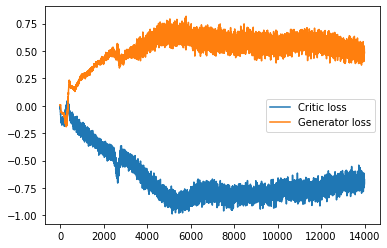

**** Iter 14000  Val ROC 0.833, AP: 0.834, EO 0.042 ****
15000  /200000   training iterations, took 2096 seconds so far...


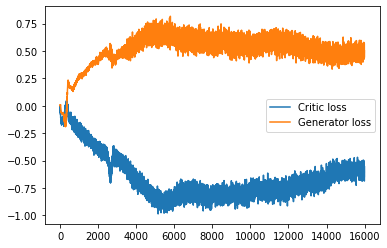

**** Iter 16000  Val ROC 0.838, AP: 0.836, EO 0.066 ****
17500  /200000   training iterations, took 2434 seconds so far...


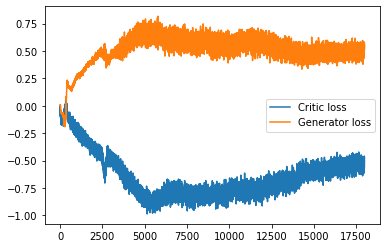

**** Iter 18000  Val ROC 0.804, AP: 0.796, EO 0.083 ****


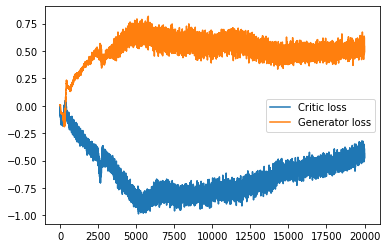

20000  /200000   training iterations, took 2772 seconds so far...
**** Iter 20000  Val ROC 0.809, AP: 0.808, EO 0.120 ****


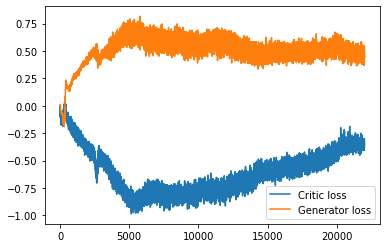

**** Iter 22000  Val ROC 0.778, AP: 0.778, EO 0.164 ****
22500  /200000   training iterations, took 3173 seconds so far...


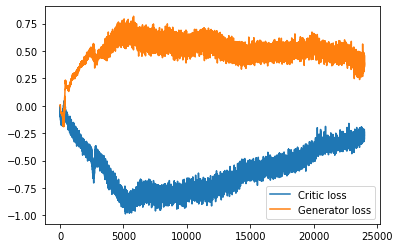

**** Iter 24000  Val ROC 0.788, AP: 0.784, EO 0.211 ****
25000  /200000   training iterations, took 3511 seconds so far...


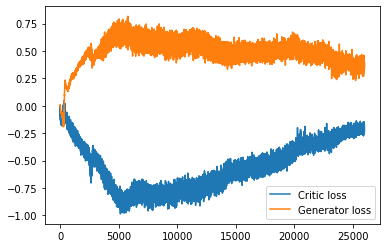

**** Iter 26000  Val ROC 0.781, AP: 0.777, EO 0.222 ****
27500  /200000   training iterations, took 3849 seconds so far...


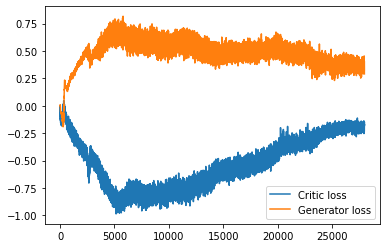

**** Iter 28000  Val ROC 0.785, AP: 0.771, EO 0.259 ****


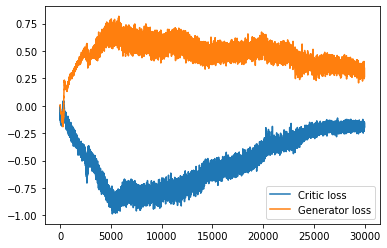

30000  /200000   training iterations, took 4187 seconds so far...
**** Iter 30000  Val ROC 0.765, AP: 0.756, EO 0.253 ****


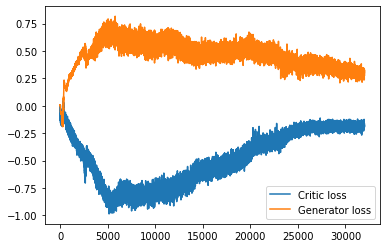

**** Iter 32000  Val ROC 0.767, AP: 0.764, EO 0.259 ****
32500  /200000   training iterations, took 4588 seconds so far...


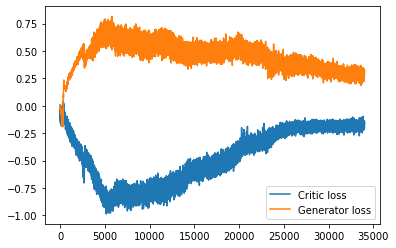

**** Iter 34000  Val ROC 0.742, AP: 0.734, EO 0.257 ****
35000  /200000   training iterations, took 4926 seconds so far...


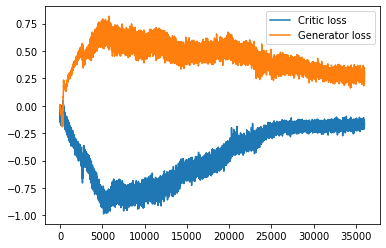

**** Iter 36000  Val ROC 0.737, AP: 0.734, EO 0.267 ****
37500  /200000   training iterations, took 5263 seconds so far...


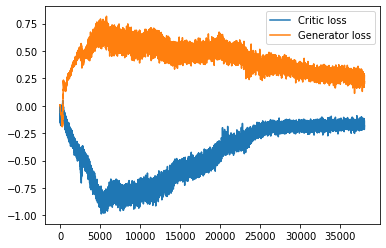

**** Iter 38000  Val ROC 0.727, AP: 0.728, EO 0.279 ****


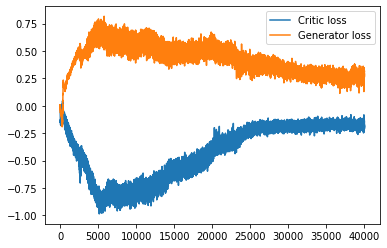

40000  /200000   training iterations, took 5601 seconds so far...
**** Iter 40000  Val ROC 0.718, AP: 0.723, EO 0.267 ****


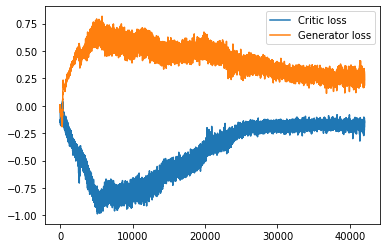

**** Iter 42000  Val ROC 0.713, AP: 0.715, EO 0.283 ****
42500  /200000   training iterations, took 6002 seconds so far...


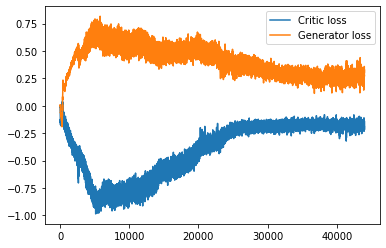

**** Iter 44000  Val ROC 0.691, AP: 0.702, EO 0.217 ****
45000  /200000   training iterations, took 6341 seconds so far...


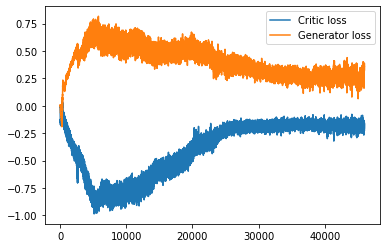

**** Iter 46000  Val ROC 0.726, AP: 0.722, EO 0.282 ****
47500  /200000   training iterations, took 6678 seconds so far...


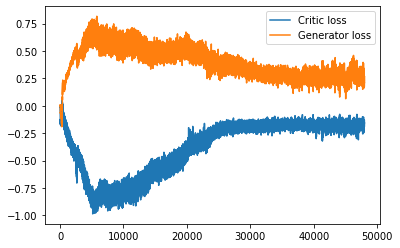

**** Iter 48000  Val ROC 0.707, AP: 0.719, EO 0.291 ****


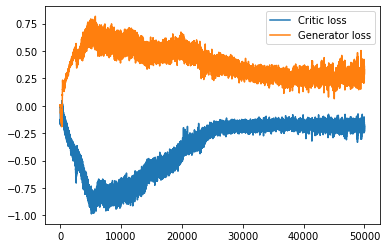

50000  /200000   training iterations, took 7016 seconds so far...
**** Iter 50000  Val ROC 0.709, AP: 0.720, EO 0.285 ****


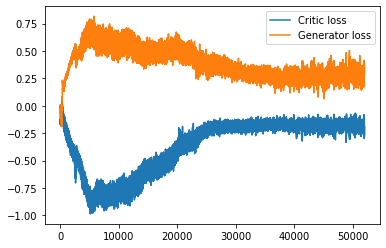

**** Iter 52000  Val ROC 0.707, AP: 0.711, EO 0.209 ****
52500  /200000   training iterations, took 7417 seconds so far...


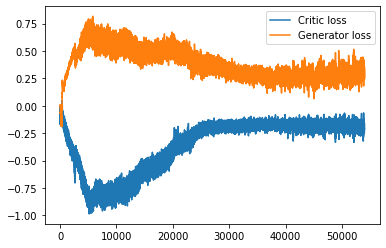

**** Iter 54000  Val ROC 0.718, AP: 0.718, EO 0.294 ****
55000  /200000   training iterations, took 7755 seconds so far...


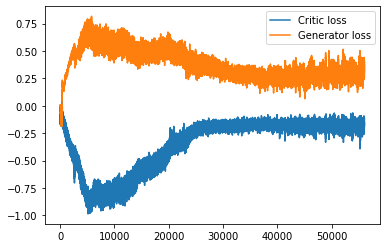

**** Iter 56000  Val ROC 0.718, AP: 0.719, EO 0.293 ****
57500  /200000   training iterations, took 8093 seconds so far...


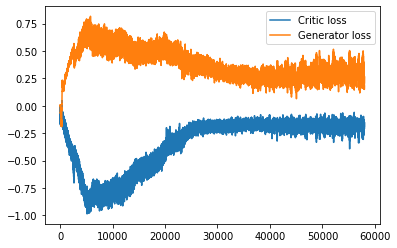

**** Iter 58000  Val ROC 0.699, AP: 0.703, EO 0.294 ****


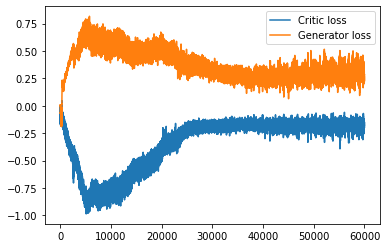

60000  /200000   training iterations, took 8431 seconds so far...
**** Iter 60000  Val ROC 0.707, AP: 0.722, EO 0.278 ****


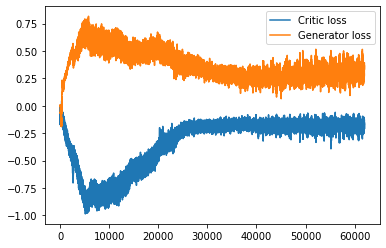

**** Iter 62000  Val ROC 0.710, AP: 0.717, EO 0.328 ****
62500  /200000   training iterations, took 8832 seconds so far...


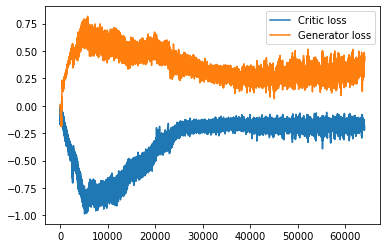

**** Iter 64000  Val ROC 0.708, AP: 0.722, EO 0.292 ****
65000  /200000   training iterations, took 9170 seconds so far...


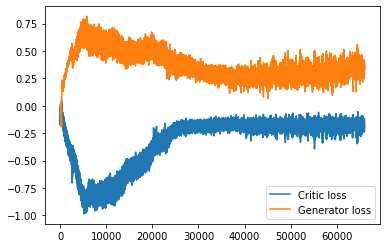

**** Iter 66000  Val ROC 0.695, AP: 0.701, EO 0.320 ****
67500  /200000   training iterations, took 9508 seconds so far...


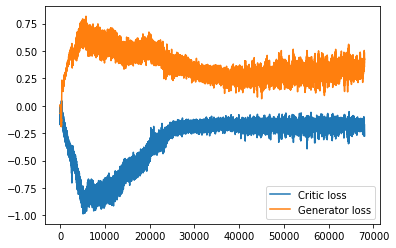

**** Iter 68000  Val ROC 0.699, AP: 0.716, EO 0.272 ****


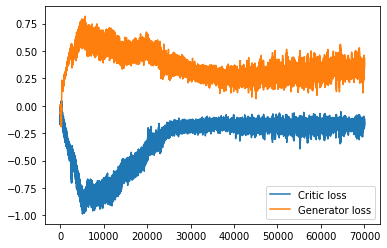

70000  /200000   training iterations, took 9846 seconds so far...
**** Iter 70000  Val ROC 0.721, AP: 0.725, EO 0.307 ****


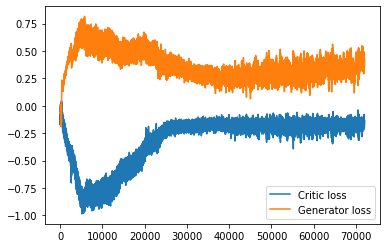

**** Iter 72000  Val ROC 0.708, AP: 0.714, EO 0.289 ****
72500  /200000   training iterations, took 10247 seconds so far...


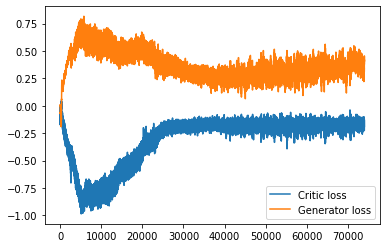

**** Iter 74000  Val ROC 0.704, AP: 0.711, EO 0.302 ****
75000  /200000   training iterations, took 10585 seconds so far...


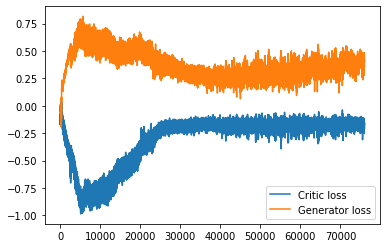

**** Iter 76000  Val ROC 0.691, AP: 0.698, EO 0.296 ****
77500  /200000   training iterations, took 10923 seconds so far...


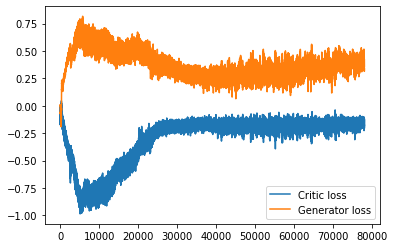

**** Iter 78000  Val ROC 0.693, AP: 0.699, EO 0.320 ****


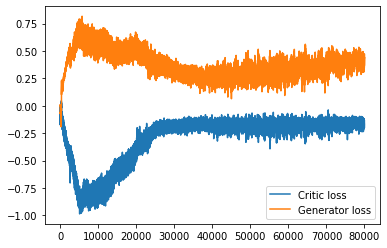

80000  /200000   training iterations, took 11261 seconds so far...
**** Iter 80000  Val ROC 0.711, AP: 0.715, EO 0.335 ****


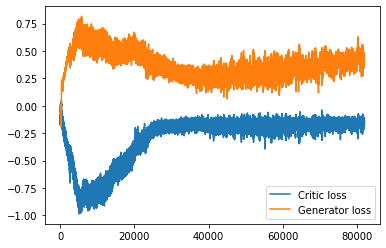

**** Iter 82000  Val ROC 0.702, AP: 0.711, EO 0.328 ****
82500  /200000   training iterations, took 11662 seconds so far...


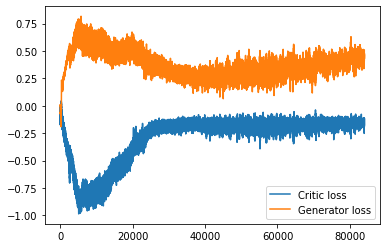

**** Iter 84000  Val ROC 0.701, AP: 0.708, EO 0.310 ****
85000  /200000   training iterations, took 11999 seconds so far...


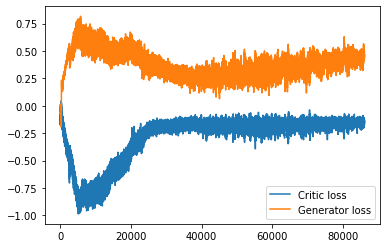

**** Iter 86000  Val ROC 0.704, AP: 0.712, EO 0.319 ****
87500  /200000   training iterations, took 12337 seconds so far...


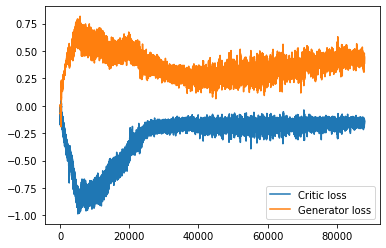

**** Iter 88000  Val ROC 0.686, AP: 0.697, EO 0.322 ****


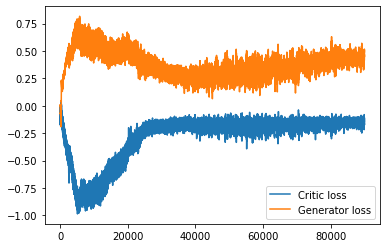

90000  /200000   training iterations, took 12675 seconds so far...
**** Iter 90000  Val ROC 0.699, AP: 0.708, EO 0.342 ****


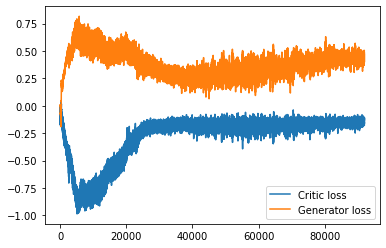

**** Iter 92000  Val ROC 0.706, AP: 0.710, EO 0.329 ****
92500  /200000   training iterations, took 13076 seconds so far...


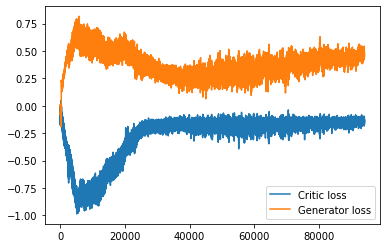

**** Iter 94000  Val ROC 0.703, AP: 0.707, EO 0.318 ****
95000  /200000   training iterations, took 13414 seconds so far...


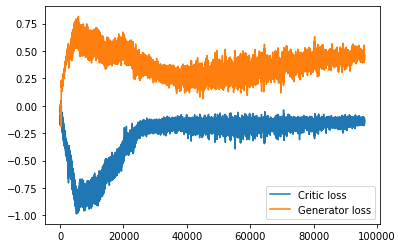

**** Iter 96000  Val ROC 0.698, AP: 0.706, EO 0.340 ****
97500  /200000   training iterations, took 13752 seconds so far...


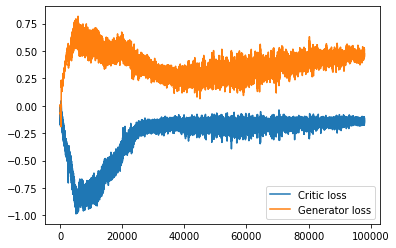

**** Iter 98000  Val ROC 0.711, AP: 0.713, EO 0.332 ****


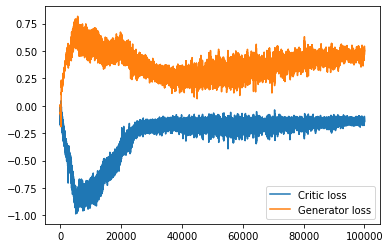

100000 /200000   training iterations, took 14090 seconds so far...
**** Iter 100000 Val ROC 0.713, AP: 0.718, EO 0.332 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


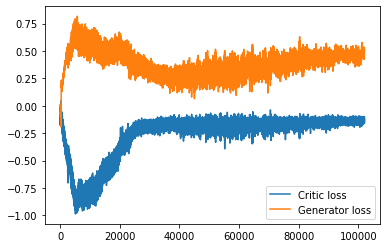

**** Iter 102000 Val ROC 0.715, AP: 0.716, EO 0.338 ****
102500 /200000   training iterations, took 14491 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


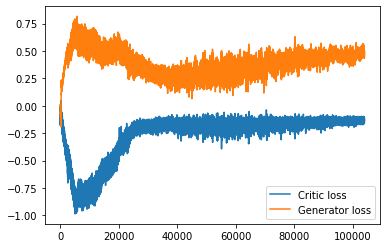

**** Iter 104000 Val ROC 0.684, AP: 0.693, EO 0.339 ****
105000 /200000   training iterations, took 14828 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


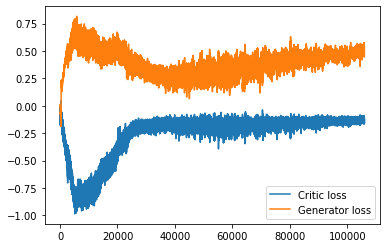

**** Iter 106000 Val ROC 0.707, AP: 0.714, EO 0.349 ****
107500 /200000   training iterations, took 15166 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


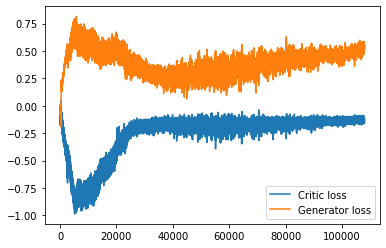

**** Iter 108000 Val ROC 0.685, AP: 0.693, EO 0.369 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


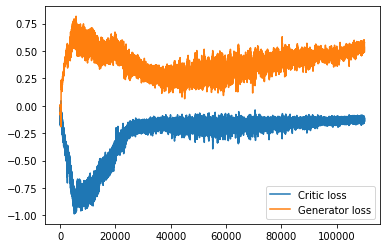

110000 /200000   training iterations, took 15505 seconds so far...
**** Iter 110000 Val ROC 0.706, AP: 0.706, EO 0.352 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


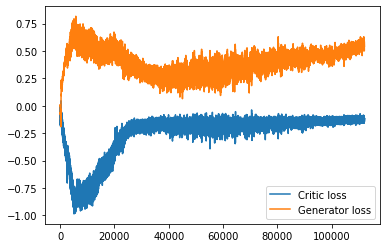

**** Iter 112000 Val ROC 0.703, AP: 0.705, EO 0.362 ****
112500 /200000   training iterations, took 15906 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


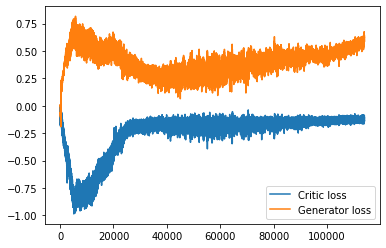

**** Iter 114000 Val ROC 0.698, AP: 0.702, EO 0.352 ****
115000 /200000   training iterations, took 16243 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


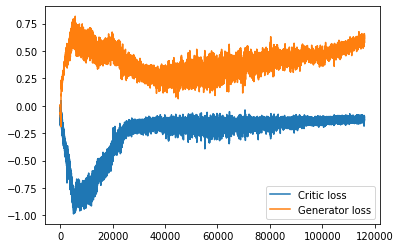

**** Iter 116000 Val ROC 0.709, AP: 0.712, EO 0.344 ****
117500 /200000   training iterations, took 16581 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


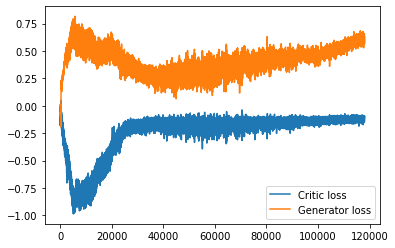

**** Iter 118000 Val ROC 0.704, AP: 0.712, EO 0.370 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


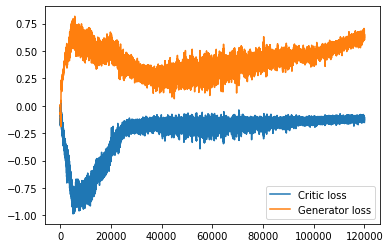

120000 /200000   training iterations, took 16919 seconds so far...
**** Iter 120000 Val ROC 0.689, AP: 0.690, EO 0.368 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


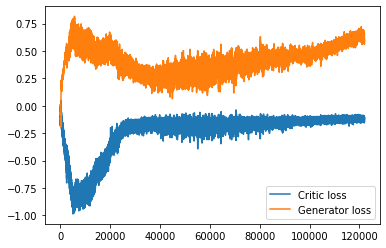

**** Iter 122000 Val ROC 0.699, AP: 0.697, EO 0.379 ****
122500 /200000   training iterations, took 17320 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


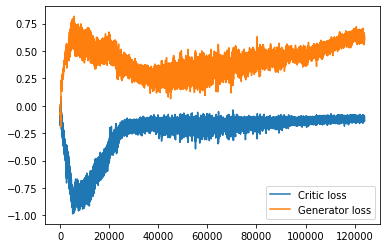

**** Iter 124000 Val ROC 0.704, AP: 0.702, EO 0.375 ****
125000 /200000   training iterations, took 17658 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


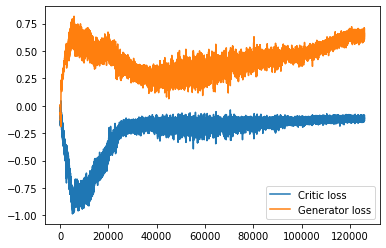

**** Iter 126000 Val ROC 0.695, AP: 0.696, EO 0.372 ****
127500 /200000   training iterations, took 17996 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


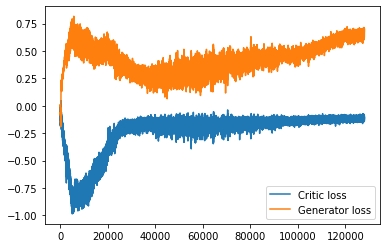

**** Iter 128000 Val ROC 0.690, AP: 0.698, EO 0.367 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


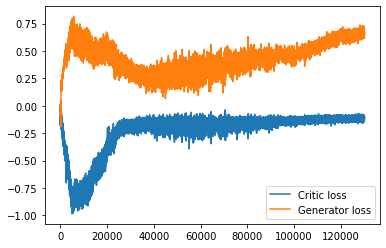

130000 /200000   training iterations, took 18334 seconds so far...
**** Iter 130000 Val ROC 0.688, AP: 0.692, EO 0.395 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


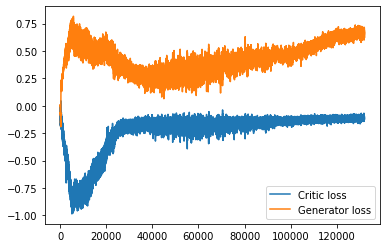

**** Iter 132000 Val ROC 0.685, AP: 0.688, EO 0.382 ****
132500 /200000   training iterations, took 18735 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


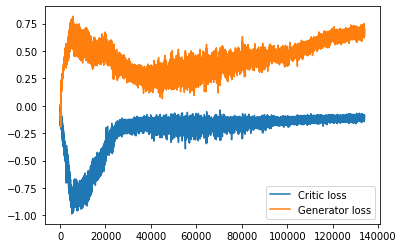

**** Iter 134000 Val ROC 0.710, AP: 0.702, EO 0.388 ****
135000 /200000   training iterations, took 19073 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


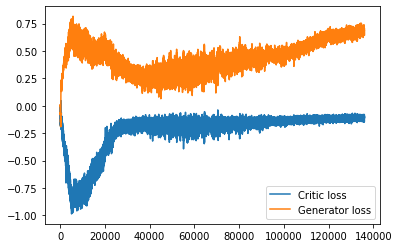

**** Iter 136000 Val ROC 0.691, AP: 0.686, EO 0.399 ****
137500 /200000   training iterations, took 19411 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


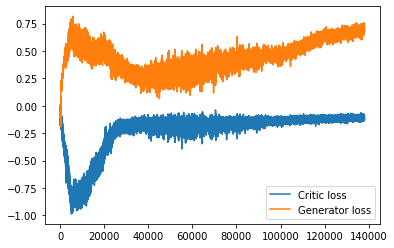

**** Iter 138000 Val ROC 0.692, AP: 0.692, EO 0.396 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


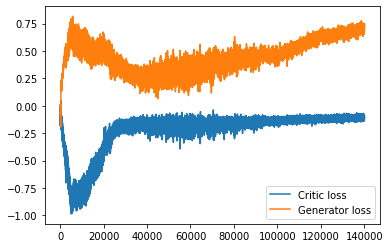

140000 /200000   training iterations, took 19749 seconds so far...
**** Iter 140000 Val ROC 0.694, AP: 0.696, EO 0.400 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


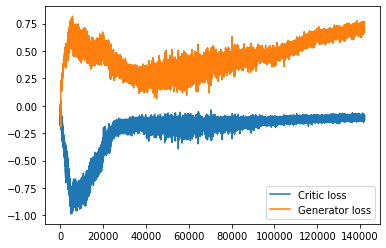

**** Iter 142000 Val ROC 0.690, AP: 0.688, EO 0.392 ****
142500 /200000   training iterations, took 20150 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


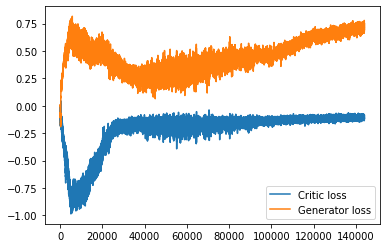

**** Iter 144000 Val ROC 0.710, AP: 0.696, EO 0.393 ****
145000 /200000   training iterations, took 20488 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


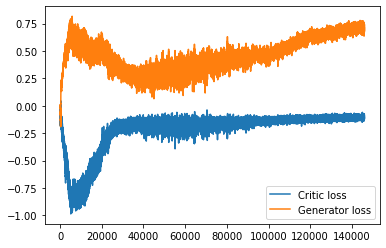

**** Iter 146000 Val ROC 0.702, AP: 0.697, EO 0.406 ****
147500 /200000   training iterations, took 20825 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


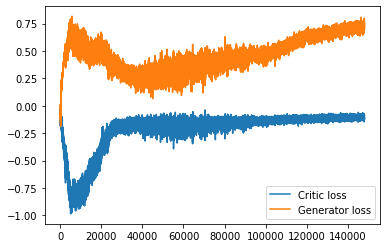

**** Iter 148000 Val ROC 0.689, AP: 0.686, EO 0.398 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


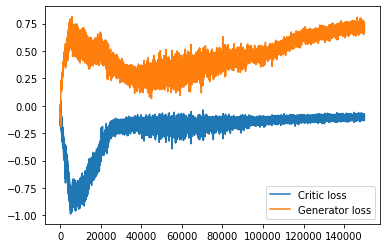

150000 /200000   training iterations, took 21163 seconds so far...
**** Iter 150000 Val ROC 0.692, AP: 0.685, EO 0.405 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


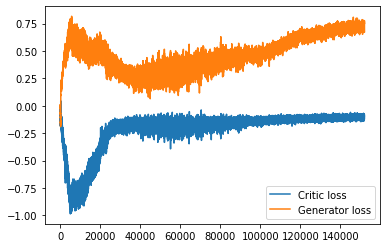

**** Iter 152000 Val ROC 0.698, AP: 0.696, EO 0.412 ****
152500 /200000   training iterations, took 21564 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


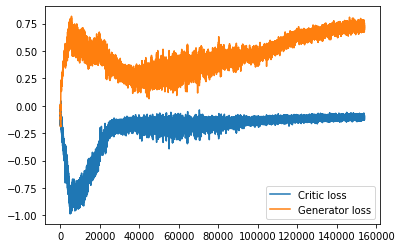

**** Iter 154000 Val ROC 0.701, AP: 0.695, EO 0.416 ****
155000 /200000   training iterations, took 21902 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


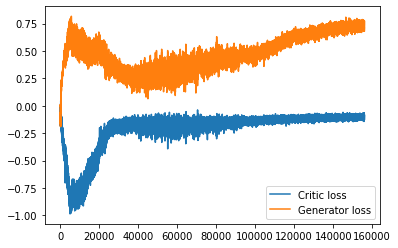

**** Iter 156000 Val ROC 0.669, AP: 0.675, EO 0.423 ****
157500 /200000   training iterations, took 22240 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


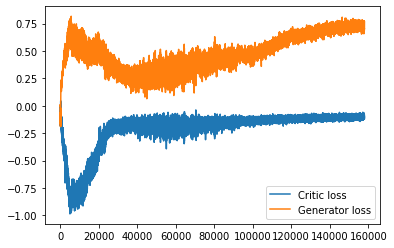

**** Iter 158000 Val ROC 0.681, AP: 0.678, EO 0.413 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


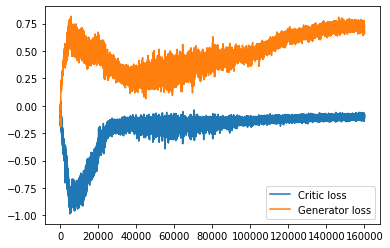

160000 /200000   training iterations, took 22578 seconds so far...
**** Iter 160000 Val ROC 0.697, AP: 0.693, EO 0.415 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


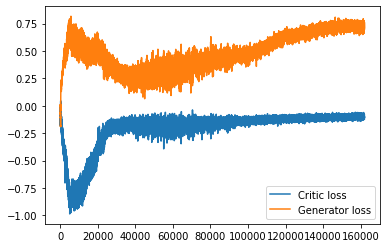

**** Iter 162000 Val ROC 0.681, AP: 0.679, EO 0.415 ****
162500 /200000   training iterations, took 22979 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


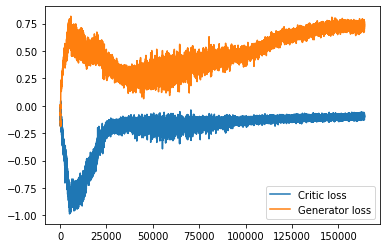

**** Iter 164000 Val ROC 0.686, AP: 0.686, EO 0.411 ****
165000 /200000   training iterations, took 23317 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


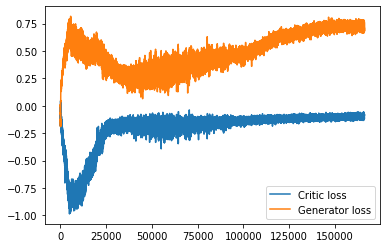

**** Iter 166000 Val ROC 0.691, AP: 0.691, EO 0.430 ****
167500 /200000   training iterations, took 23654 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


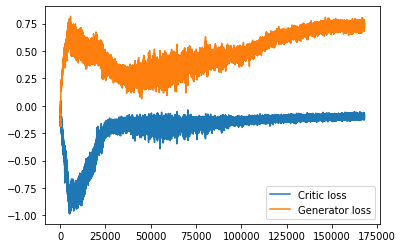

**** Iter 168000 Val ROC 0.694, AP: 0.686, EO 0.412 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


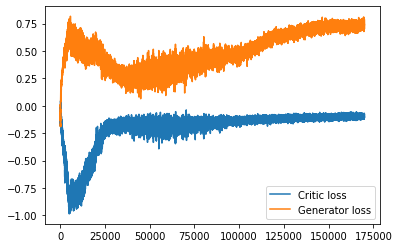

170000 /200000   training iterations, took 23993 seconds so far...
**** Iter 170000 Val ROC 0.699, AP: 0.699, EO 0.422 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


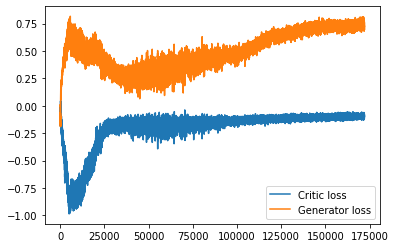

**** Iter 172000 Val ROC 0.687, AP: 0.682, EO 0.423 ****
172500 /200000   training iterations, took 24394 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


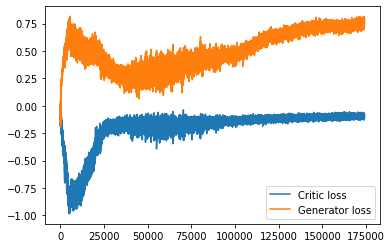

**** Iter 174000 Val ROC 0.686, AP: 0.680, EO 0.427 ****
175000 /200000   training iterations, took 24732 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


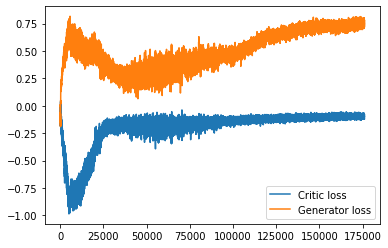

**** Iter 176000 Val ROC 0.694, AP: 0.686, EO 0.435 ****
177500 /200000   training iterations, took 25070 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


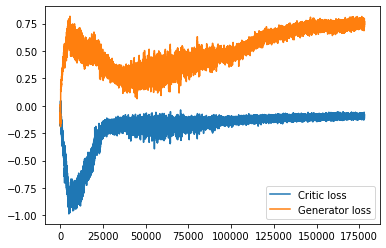

**** Iter 178000 Val ROC 0.670, AP: 0.672, EO 0.423 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


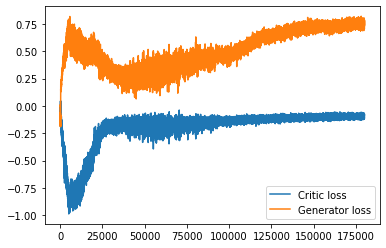

180000 /200000   training iterations, took 25409 seconds so far...
**** Iter 180000 Val ROC 0.695, AP: 0.688, EO 0.443 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


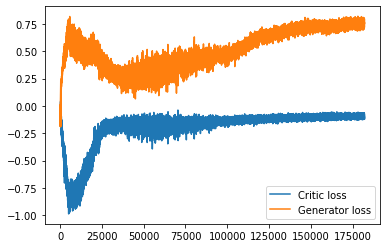

**** Iter 182000 Val ROC 0.681, AP: 0.675, EO 0.431 ****
182500 /200000   training iterations, took 25811 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


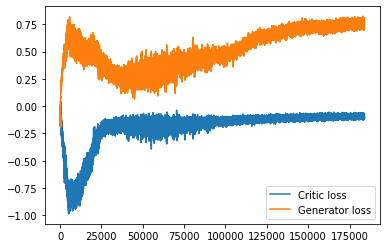

**** Iter 184000 Val ROC 0.676, AP: 0.677, EO 0.451 ****
185000 /200000   training iterations, took 26149 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


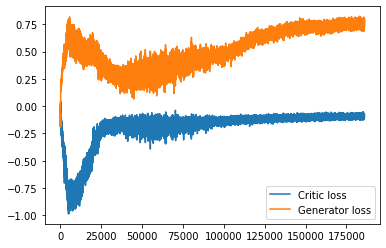

**** Iter 186000 Val ROC 0.676, AP: 0.672, EO 0.441 ****
187500 /200000   training iterations, took 26487 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


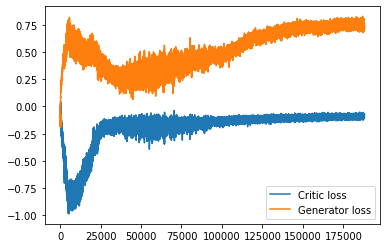

**** Iter 188000 Val ROC 0.689, AP: 0.682, EO 0.454 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


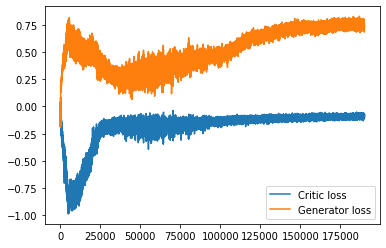

190000 /200000   training iterations, took 26825 seconds so far...
**** Iter 190000 Val ROC 0.689, AP: 0.683, EO 0.463 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


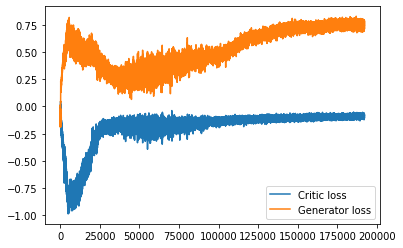

**** Iter 192000 Val ROC 0.694, AP: 0.688, EO 0.449 ****
192500 /200000   training iterations, took 27227 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


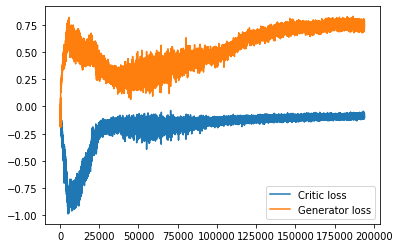

**** Iter 194000 Val ROC 0.674, AP: 0.670, EO 0.459 ****
195000 /200000   training iterations, took 27566 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


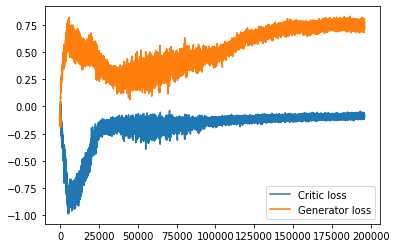

**** Iter 196000 Val ROC 0.675, AP: 0.670, EO 0.457 ****
197500 /200000   training iterations, took 27905 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


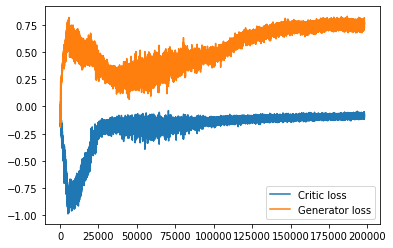

**** Iter 198000 Val ROC 0.683, AP: 0.675, EO 0.456 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


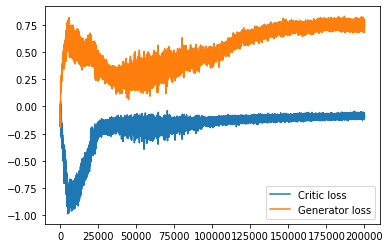

**** Training completed after 199999 iterations. ****


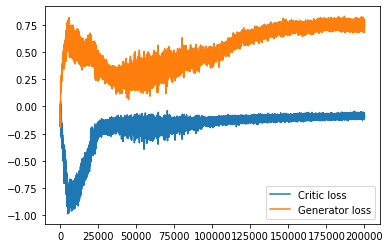

**** Using EO criterion of 0.52 for early stopping
**** Saving snapshots into ../snapshots/model_best_57.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****


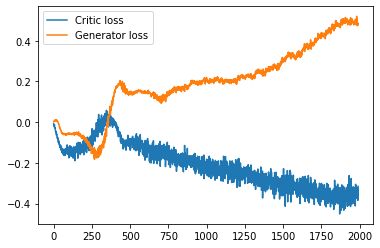

**** Iter 2000   Val ROC 0.859, AP: 0.859, EO 0.002 ****
2500   /200000   training iterations, took 340 seconds so far...


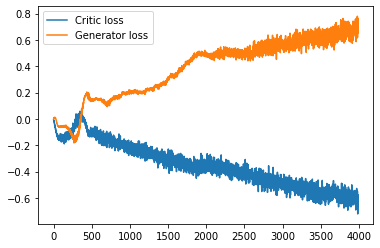

**** Iter 4000   Val ROC 0.851, AP: 0.850, EO 0.010 ****
5000   /200000   training iterations, took 678 seconds so far...


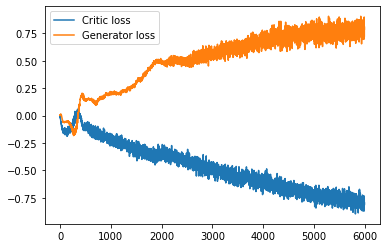

**** Iter 6000   Val ROC 0.860, AP: 0.857, EO 0.017 ****
7500   /200000   training iterations, took 1015 seconds so far...


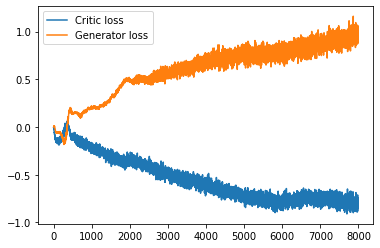

**** Iter 8000   Val ROC 0.851, AP: 0.855, EO 0.011 ****


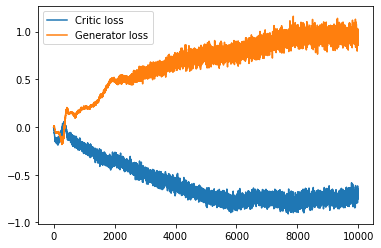

10000  /200000   training iterations, took 1352 seconds so far...
**** Iter 10000  Val ROC 0.840, AP: 0.846, EO 0.033 ****


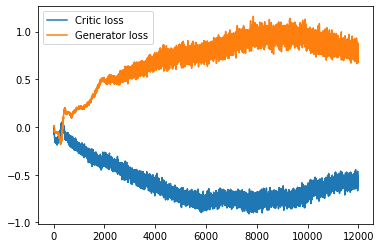

**** Iter 12000  Val ROC 0.837, AP: 0.834, EO 0.054 ****
12500  /200000   training iterations, took 1753 seconds so far...


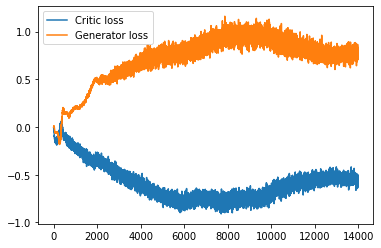

**** Iter 14000  Val ROC 0.824, AP: 0.824, EO 0.085 ****
15000  /200000   training iterations, took 2090 seconds so far...


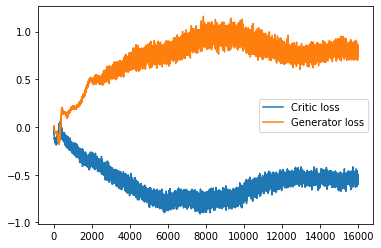

**** Iter 16000  Val ROC 0.833, AP: 0.829, EO 0.100 ****
17500  /200000   training iterations, took 2427 seconds so far...


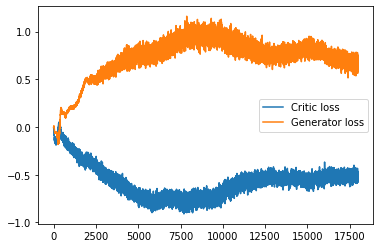

**** Iter 18000  Val ROC 0.821, AP: 0.820, EO 0.107 ****


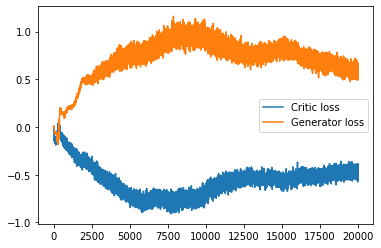

20000  /200000   training iterations, took 2764 seconds so far...
**** Iter 20000  Val ROC 0.829, AP: 0.821, EO 0.123 ****


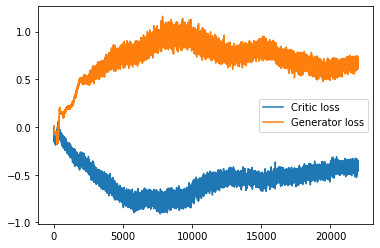

**** Iter 22000  Val ROC 0.828, AP: 0.821, EO 0.138 ****
22500  /200000   training iterations, took 3165 seconds so far...


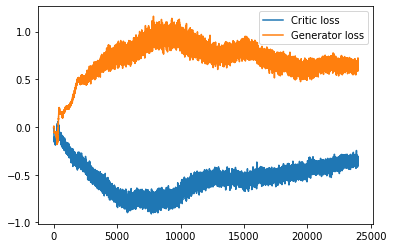

**** Iter 24000  Val ROC 0.840, AP: 0.830, EO 0.146 ****
25000  /200000   training iterations, took 3502 seconds so far...


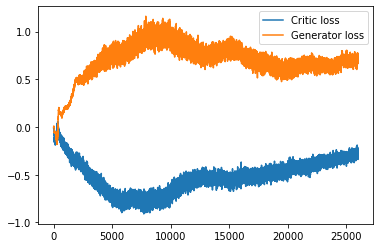

**** Iter 26000  Val ROC 0.825, AP: 0.814, EO 0.181 ****
27500  /200000   training iterations, took 3839 seconds so far...


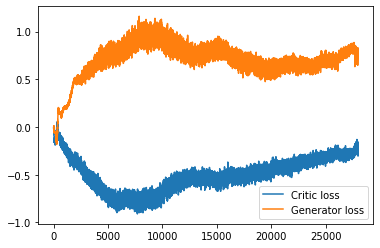

**** Iter 28000  Val ROC 0.787, AP: 0.783, EO 0.165 ****


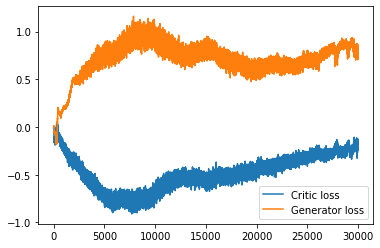

30000  /200000   training iterations, took 4176 seconds so far...
**** Iter 30000  Val ROC 0.797, AP: 0.791, EO 0.213 ****


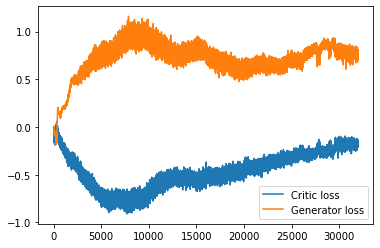

**** Iter 32000  Val ROC 0.771, AP: 0.772, EO 0.259 ****
32500  /200000   training iterations, took 4576 seconds so far...


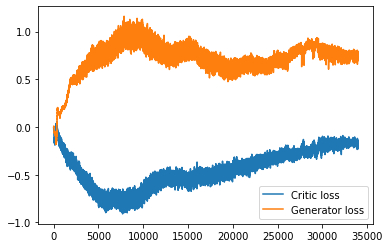

**** Iter 34000  Val ROC 0.774, AP: 0.770, EO 0.262 ****
35000  /200000   training iterations, took 4913 seconds so far...


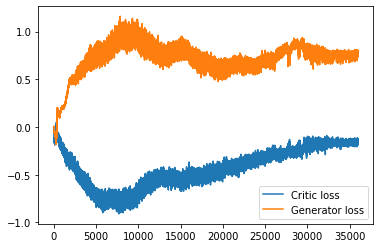

**** Iter 36000  Val ROC 0.757, AP: 0.758, EO 0.260 ****
37500  /200000   training iterations, took 5250 seconds so far...


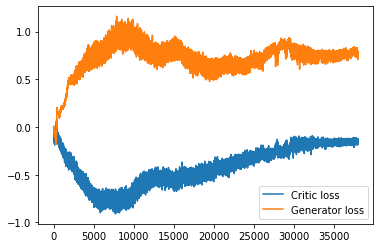

**** Iter 38000  Val ROC 0.737, AP: 0.739, EO 0.274 ****


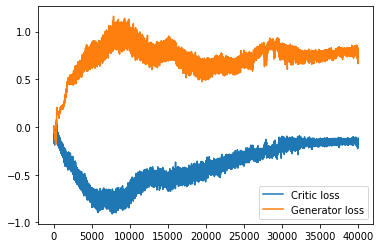

40000  /200000   training iterations, took 5587 seconds so far...
**** Iter 40000  Val ROC 0.737, AP: 0.739, EO 0.274 ****


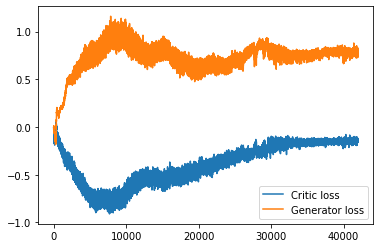

**** Iter 42000  Val ROC 0.718, AP: 0.725, EO 0.272 ****
42500  /200000   training iterations, took 5988 seconds so far...


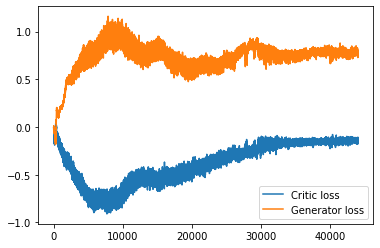

**** Iter 44000  Val ROC 0.733, AP: 0.740, EO 0.308 ****
45000  /200000   training iterations, took 6325 seconds so far...


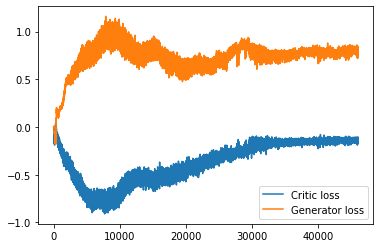

**** Iter 46000  Val ROC 0.716, AP: 0.720, EO 0.311 ****
47500  /200000   training iterations, took 6661 seconds so far...


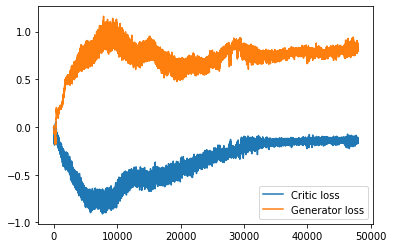

**** Iter 48000  Val ROC 0.727, AP: 0.730, EO 0.292 ****


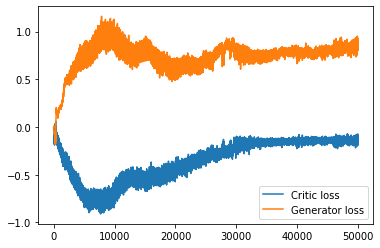

50000  /200000   training iterations, took 6998 seconds so far...
**** Iter 50000  Val ROC 0.705, AP: 0.711, EO 0.289 ****


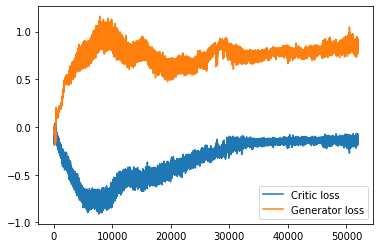

**** Iter 52000  Val ROC 0.711, AP: 0.720, EO 0.313 ****
52500  /200000   training iterations, took 7398 seconds so far...


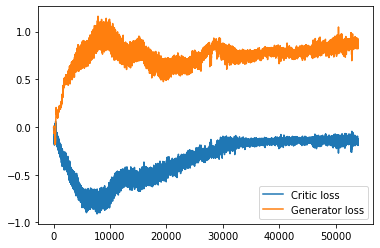

**** Iter 54000  Val ROC 0.696, AP: 0.705, EO 0.292 ****
55000  /200000   training iterations, took 7736 seconds so far...


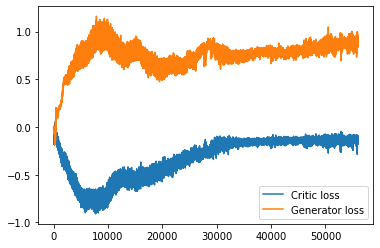

**** Iter 56000  Val ROC 0.733, AP: 0.737, EO 0.320 ****
57500  /200000   training iterations, took 8072 seconds so far...


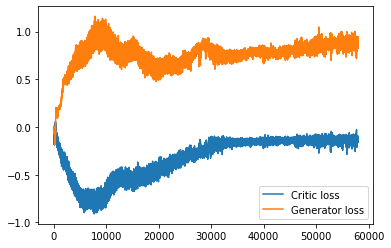

**** Iter 58000  Val ROC 0.702, AP: 0.706, EO 0.296 ****


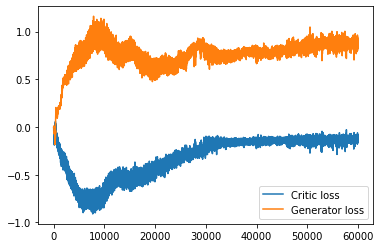

60000  /200000   training iterations, took 8409 seconds so far...
**** Iter 60000  Val ROC 0.720, AP: 0.722, EO 0.336 ****


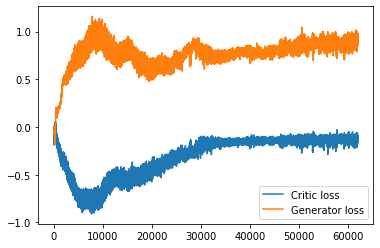

**** Iter 62000  Val ROC 0.716, AP: 0.721, EO 0.342 ****
62500  /200000   training iterations, took 8809 seconds so far...


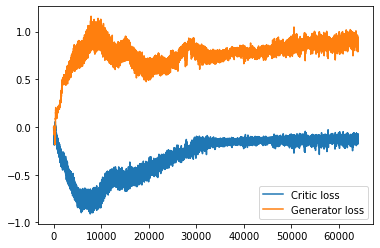

**** Iter 64000  Val ROC 0.709, AP: 0.710, EO 0.327 ****
65000  /200000   training iterations, took 9146 seconds so far...


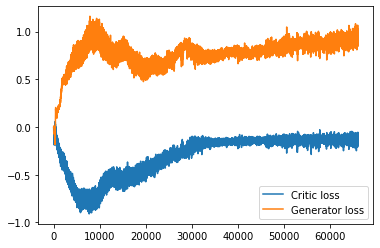

**** Iter 66000  Val ROC 0.706, AP: 0.707, EO 0.341 ****
67500  /200000   training iterations, took 9483 seconds so far...


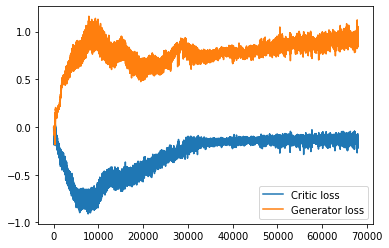

**** Iter 68000  Val ROC 0.709, AP: 0.710, EO 0.338 ****


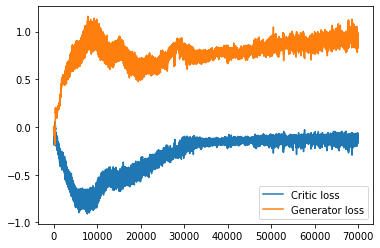

70000  /200000   training iterations, took 9820 seconds so far...
**** Iter 70000  Val ROC 0.699, AP: 0.709, EO 0.352 ****


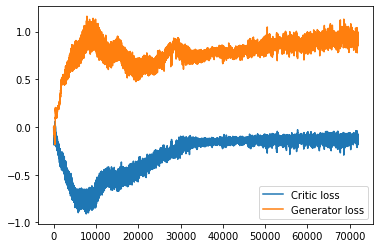

**** Iter 72000  Val ROC 0.697, AP: 0.699, EO 0.338 ****
72500  /200000   training iterations, took 10219 seconds so far...


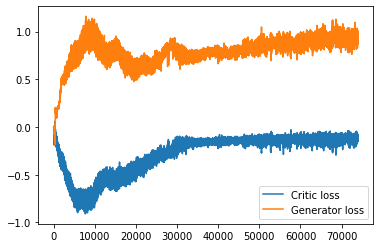

**** Iter 74000  Val ROC 0.719, AP: 0.710, EO 0.346 ****
75000  /200000   training iterations, took 10556 seconds so far...


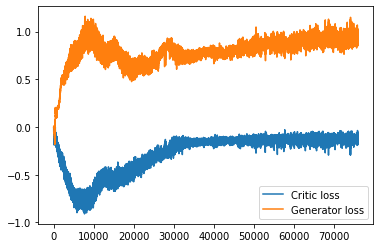

**** Iter 76000  Val ROC 0.731, AP: 0.727, EO 0.361 ****
77500  /200000   training iterations, took 10893 seconds so far...


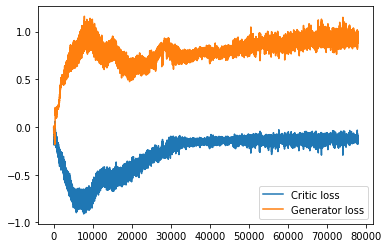

**** Iter 78000  Val ROC 0.714, AP: 0.712, EO 0.367 ****


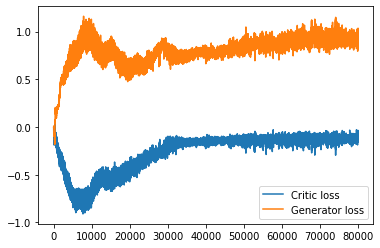

80000  /200000   training iterations, took 11230 seconds so far...
**** Iter 80000  Val ROC 0.683, AP: 0.689, EO 0.344 ****


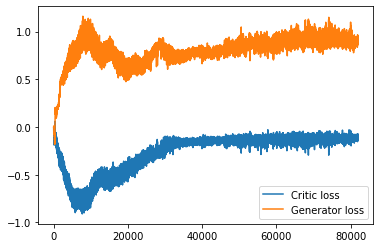

**** Iter 82000  Val ROC 0.725, AP: 0.719, EO 0.383 ****
82500  /200000   training iterations, took 11630 seconds so far...


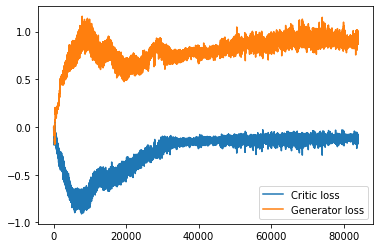

**** Iter 84000  Val ROC 0.706, AP: 0.701, EO 0.359 ****
85000  /200000   training iterations, took 11968 seconds so far...


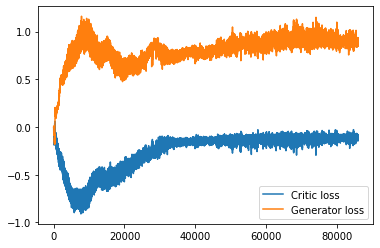

**** Iter 86000  Val ROC 0.708, AP: 0.700, EO 0.373 ****
87500  /200000   training iterations, took 12309 seconds so far...


In [ ]:
train_to_eo_and_save_models(target_eo=.52,
                            num_models=5,
                            dataset=dataset,
                            train_graph=train_graph,
                            val_ones=val_ones,
                            val_zeros=val_zeros)

## Graph Generation

In [6]:
def get_model_path(dataset, target_eo, i, str_len):
    directory = os.path.join('../models',
                             dataset,
                             f'netgan_eo_{int(100*target_eo)}')
    return os.path.join(directory, f'model_{i:0{str_len}d}.ckpt')

In [6]:
def graphs_from_models(train_graph,
                       models_path,
                       graphs_path,
                       num_models,
                       val_ones,
                       val_zeros,
                       rw_len = 16,
                       batch_size = 128):
    walker = netgan.utils.RandomWalker(train_graph, rw_len=rw_len, p=1, q=1, batch_size=batch_size)
    # define model
    model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                          use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                          W_down_generator_size=128, l2_penalty_generator=1e-7,
                          l2_penalty_discriminator=5e-5, generator_layers=[40],
                          discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
    
    str_len = len(str(num_models-1))
    saver = tf.train.Saver()
    for i in range(num_models):
        saver.restore(model.session, os.path.join(models_path, f'model_{i:0{str_len}d}.ckpt'))
        sample_many = model.generate_discrete(10000, reuse=True, legacy=False)
        start = time.time()
        rws = netgan.utils.sample_rws(sampler=sample_many, sampler_args={model.tau: 0.5}, steps=6000)
        scores_matrix = netgan.utils.score_matrix_from_random_walks(rws, train_graph.shape[0])
        scores_matrix = scores_matrix.toarray()
        sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum()/2)
        timing = time.time() - start
        
        experiment_path = os.path.join(graphs_path, f'Experiment_{i:0{str_len}d}')
        sampled_graphs_path = os.path.join(experiment_path, 'sampled_graphs')
        scores_matrix_path = os.path.join(experiment_path, 'scores_matrix')
        Path(sampled_graphs_path).mkdir(parents=True, exist_ok=True)
        Path(scores_matrix_path).mkdir(parents=True, exist_ok=True)
        
        # save scores
        np.save(os.path.join(scores_matrix_path, 'scores_matrix_1'), scores_matrix)
        
        # save graph
        save_npz(file=os.path.join(sampled_graphs_path, 'graph_1'), matrix=sampled_graph)
        
        utils.save_dict({1: timing}, os.path.join(sampled_graphs_path, 'timing.pickle'))
        # compute eo:
        overlap = 2 * utils.edge_overlap(train_graph, sampled_graph) / train_graph.sum()
        utils.save_dict({1: overlap}, os.path.join(sampled_graphs_path, 'overlap.pickle'))
        # link prediction performance:
        roc_auc, avg_prec = utils.link_prediction_performance(scores_matrix, val_ones, val_zeros)
        utils.save_dict({1: roc_auc}, os.path.join(sampled_graphs_path, 'ROC-AUC.pickle'))
        utils.save_dict({1: avg_prec}, os.path.join(sampled_graphs_path, 'avg_prec.pickle'))

In [7]:
target_eo = .52
graphs_from_models(train_graph=train_graph,
                   models_path=os.path.join('../models',
                                            dataset,
                                            f'netgan_eo_{int(100*target_eo)}'),
                   graphs_path=os.path.join('../logs/',
                                            dataset,
                                            f'baseline_Netgan_sample_many_eo_{int(100*target_eo)}'),
                   num_models=5,
                   val_ones=test_ones,
                   val_zeros=test_zeros)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/web_edu/netgan_eo_52/model_0.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


INFO:tensorflow:Restoring parameters from ../models/web_edu/netgan_eo_52/model_1.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


INFO:tensorflow:Restoring parameters from ../models/web_edu/netgan_eo_52/model_2.ckpt


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


INFO:tensorflow:Restoring parameters from ../models/web_edu/netgan_eo_52/model_3.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


INFO:tensorflow:Restoring parameters from ../models/web_edu/netgan_eo_52/model_4.ckpt


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [7]:
rw_len = 16
batch_size = 128
walker = netgan.utils.RandomWalker(train_graph, rw_len=rw_len, p=1, q=1, batch_size=batch_size)

In [8]:
model = netgan.NetGAN(_N, rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
saver = tf.train.Saver()

In [26]:
saver.restore(model.session, get_model_path(dataset, .52, 1, 1))

INFO:tensorflow:Restoring parameters from ../models/CORA_ML/netgan_eo_52/model_1.ckpt


In [18]:
sample_many = model.generate_discrete(10000, reuse=True, legacy=False)

In [20]:
rws = netgan.utils.sample_rws(sampler=sample_many, sampler_args={model.tau: 0.5}, steps=600)

500


In [21]:
scores_matrix = netgan.utils.score_matrix_from_random_walks(rws, _N)

In [22]:
scores_matrix = scores_matrix.toarray()

In [27]:
sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


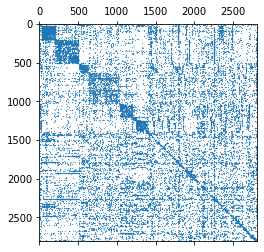

In [28]:
plt.spy(sampled_graph, markersize=.2)
plt.show()